In [1]:
!date

Thu Feb 27 16:19:17 PST 2020


# Redoing analysis of tSS

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from scipy import stats
from scipy.optimize import curve_fit
import ast
from scipy.stats import sem
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp, ttest_ind
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
gene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
isoform.var["idx"] = np.arange(isoform.var.shape[0])

# New t2g

In [5]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)

In [6]:
def swap_start(start, stop, strand):
    new_start = start
    new_stop = stop
    if strand=="-":
        new_start = stop
        new_stop = start
    return new_start, new_stop

In [7]:
tmp = t2g.apply(lambda x: swap_start(x["start"], x["stop"], x["strand"]), axis=1).tolist()
t2g[["new_start", "new_stop"]] = pd.DataFrame(tmp, columns=["new_start", "new_stop"])

# Group isoforms by (1) Gene and then (2) Transcripton start sites

In [8]:
gb = t2g.groupby(["chromosome", "gene_name", "new_start"])["transcript_name"].apply(list)
gb = gb.reset_index()
gb = gb.rename(columns={"transcript_name":"tss_same"})
gb["tss_len"] = gb["tss_same"].apply(lambda x: len(x))

In [9]:
gb["n_tss_same"] = gb["tss_same"].apply(lambda x: len(x))

num_iso_per_gene = t2g.groupby("gene_name")["transcript_name"].count()
max_tss_set_size = gb.groupby("gene_name")["tss_len"].apply(max)
num_tss_with_1_iso = gb.groupby("gene_name")["tss_len"].apply(lambda x: (np.array(x)==1).sum())

gb["n_iso"] = gb["gene_name"].map(num_iso_per_gene)
gb["max_tss_size"] = gb["gene_name"].map(max_tss_set_size)
gb["num_tss_1_iso"] = gb["gene_name"].map(num_tss_with_1_iso)

txn_list = gb["tss_same"].explode().values

#gb["tss_same"] = gb.tss_same.astype(str)
gb["tss_class"] = np.arange(gb.shape[0])

In [10]:
## Conditions
# 1. n_iso per gene > 2
# 2. 2< n_TSS_same < n_iso
mask = np.logical_and(gb["max_tss_size"]>1, np.logical_and(gb["n_iso"] > 2, gb["n_tss_same"] < gb["n_iso"]))

ft2g = gb[mask]

In [11]:
# remove the tss classes where a single isoform has been discarded
ft2g["filter"] = ft2g.tss_same.apply(lambda x: np.array([i not in isoform.var.index.values for i in x]).sum())
ft2g = ft2g[ft2g["filter"]==0]

In [97]:
et2g = ft2g.explode("tss_same")

In [12]:
dtss_tname = ft2g["tss_same"].to_dict()
l = list(dtss_tname.values())
flatten = lambda l: [item for sublist in l for item in sublist]
lf = flatten(l)

In [13]:
tmp_iso = isoform[:, isoform.var.transcript_name.isin(lf)]
tmp_iso

View of AnnData object with n_obs × n_vars = 6043 × 29963 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'idx'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [15]:
def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new entry
                inverse[item] = key
    return inverse

In [16]:
dtname_tss = invert_dict(dtss_tname)
tmp_iso.var["tss_class"] = tmp_iso.var.index.map(dtname_tss)

Trying to set attribute `.var` of view, copying.


In [17]:
(~ft2g[ft2g["tss_class"].isin(tmp_iso.var["tss_class"])]["tss_same"].explode().isin(isoform.var.index)).sum()

0

In [18]:
def sum_tss_same(mtx, components, features):
    
    unique = np.unique(features)
    nuniq = unique.shape[0]
    ncomp = components.shape[0]
    
    s_mtx = np.zeros((ncomp, nuniq))
    
    for uidx, u in enumerate(unique):
        mask = features == u
        s_mtx[:,uidx] = np.asarray(mtx[:,mask].sum(axis=1)).reshape(-1)
    
    return s_mtx, unique

In [19]:
# sum the isoforms with the same start site
features = tmp_iso.var.tss_class.values
components = tmp_iso.obs.cell_id.values
mtx = tmp_iso.layers["X"].todense()
# sum the raw counts then normalize and log?

mtx, unique = sum_tss_same(mtx, components, features)

In [22]:
X = mtx
obs = isoform.obs
var = ft2g.loc[unique]
var["idx"] = np.arange(var.shape[0])

stss = anndata.AnnData(X=X, obs=obs, var=var)
stss.var.index = stss.var.index.astype(int)

Transforming to str index.


In [23]:
# tss = stss.var.index.values
# txn = tmp_iso.var.index.values
# 
# tss_idx = np.arange(len(tss))
# txn_idx = np.arange(len(txn))
# tss_n_same = stss.var.n_tss_same
# 
# dtss_idx = dict(zip(tss, tss_idx))
# dtss_n_same = dict(zip(tss, tss_n_same))

# Now log1p them and then perform the ops on that

In [24]:
stss.layers["X"] = X
scanp.pp.log1p(stss)

In [25]:
stss.layers["log1p"] = stss.X.copy()

In [26]:
scanp.pp.scale(stss, max_value=10)

In [27]:
# i2tss["tss_class_idx"] = i2tss["tss_class"].map(dtss_idx)
# i2tss["tss_n_same"] = i2tss["tss_class"].map(dtss_n_same)

In [28]:
stss

AnnData object with n_obs × n_vars = 6043 × 24916 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'chromosome', 'gene_name', 'new_start', 'tss_same', 'tss_len', 'n_tss_same', 'n_iso', 'max_tss_size', 'num_tss_1_iso', 'tss_class', 'filter', 'idx'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [29]:
tmp_iso

AnnData object with n_obs × n_vars = 6043 × 29963 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'idx', 'tss_class'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [371]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.05, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    corr_method = kwargs.get("corr_method", "bonferroni")
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate")
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [457]:
################################################################
################################################################
################################################################
################################################################
def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    corr_method = kwargs.get("corr_method", "bonferroni")
    grouping = kwargs.get("grouping", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)
    
    

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, _ = split_by_target(mat, assignments, t, axis=0)
        
         # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        nan_mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)
        
        t_mat = t_mat[:, nan_mask]
        
        
        nan_grouping = grouping[nan_mask]
        unique_group = np.unique(nan_grouping)
        
        ## Added section
        plist = []
        tlist = []
        for gidx, g in enumerate(unique_group):
            if gidx%1000==0:
                logging.debug("{} of {} genes".format(gidx+1, unique_group.shape[0]))
            tg_mat, _ = split_by_target(t_mat, nan_grouping, g, axis=1)
            ones = np.ones(tg_mat.shape[1])
            mask = np.diag(ones).astype(bool)
            pv = []
            for row in mask:
                test = ttest_ind(tg_mat[:,row], tg_mat[:,~row].mean(axis=1))

                p = test.pvalue[0]
                s = test.statistic[0]
                
                plist.append(p)
                tlist.append(s)
        
        # print(plist)
        # print(tlist)
        pval[tidx,:][nan_mask] = plist
        stat[tidx,:][nan_mask] = tlist
            
        ## Added section
        
        # pval[tidx,:][mask] = pvalue
        # stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [326]:
np.diag([1,1,1])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [325]:
stss.var["gene_name"]

87        2310035C23Rik
88        2310035C23Rik
89        2310035C23Rik
90        2310035C23Rik
91        2310035C23Rik
              ...      
101796          Eif2s3y
101797          Eif2s3y
101798          Eif2s3y
101799          Eif2s3y
101800          Eif2s3y
Name: gene_name, Length: 24916, dtype: object

In [475]:
%%time

mat         = stss.layers["log1p"]
components  = stss.obs.cell_id.values
f_tss    = stss.var.tss_class.values
assignments = stss.obs.class_label.values
grouping = stss.var["gene_name"].values

pval, stat = dexpress(mat, components, f_tss, assignments, nan_cutoff=0.8, grouping=grouping)

#one_side_mask = stat<=0
#stat[one_side_mask] = np.nan
#pval[one_side_mask] = np.nan
#pval = pval/2
# pval_stss_corr = correct_pval(pval, "bonferroni")
# 
# stat_stss = stat

27-Feb-20 21:45:04 - 1 of 4 assignments: GABAergic
27-Feb-20 21:45:05 - 1 of 701 genes
27-Feb-20 21:45:06 - 2 of 4 assignments: Glutamatergic
27-Feb-20 21:45:06 - 1 of 1337 genes
27-Feb-20 21:45:18 - 1001 of 1337 genes
27-Feb-20 21:45:22 - 3 of 4 assignments: Low Quality
27-Feb-20 21:45:22 - 1 of 954 genes
27-Feb-20 21:45:23 - 4 of 4 assignments: Non-Neuronal
27-Feb-20 21:45:23 - 1 of 108 genes


CPU times: user 9.17 s, sys: 9.89 s, total: 19.1 s
Wall time: 19.1 s


In [476]:
pval_stss = correct_pval(pval, "bonferroni")
stat_stss = stat

In [477]:
(~np.isnan(pval[0])).sum()

486

array([-16.806587], dtype=float32)

In [383]:
tmp_iso = tmp_iso[:,stss.var.tss_same.explode().values]

In [478]:
%%time

mat         = tmp_iso.layers["log1p"].todense()
components  = tmp_iso.obs.cell_id.values
f_iso    = tmp_iso.var.transcript_name.values
assignments = tmp_iso.obs.class_label.values
grouping = tmp_iso.var['gene_name'].values

pval, stat = dexpress(mat, components, f_iso, assignments, nan_cutoff=0.8, grouping=grouping)

#one_side_mask = stat>0
#stat[one_side_mask] = np.nan
#pval[one_side_mask] = np.nan
#pval = pval

pval_iso = correct_pval(pval, "bonferroni")
stat_iso = stat

27-Feb-20 21:45:28 - 1 of 4 assignments: GABAergic
27-Feb-20 21:45:28 - 1 of 628 genes
27-Feb-20 21:45:29 - 2 of 4 assignments: Glutamatergic
27-Feb-20 21:45:30 - 1 of 1209 genes
27-Feb-20 21:45:38 - 1001 of 1209 genes
27-Feb-20 21:45:40 - 3 of 4 assignments: Low Quality
27-Feb-20 21:45:40 - 1 of 895 genes
27-Feb-20 21:45:41 - 4 of 4 assignments: Non-Neuronal
27-Feb-20 21:45:41 - 1 of 99 genes


CPU times: user 10.8 s, sys: 3.28 s, total: 14.1 s
Wall time: 14.1 s


In [479]:
(stss.var["tss_same"].explode()!=features).sum()

0

In [480]:
repeat_col = stss.var["n_tss_same"]

f_tss_ext = np.repeat(f_tss ,repeat_col)

p1_tmp = pval_iso
p2_tmp = np.repeat(pval_stss ,repeat_col, axis=1)

s1_tmp = stat_iso
s2_tmp = np.repeat(stat_stss ,repeat_col, axis=1)

In [500]:
alpha = 0.05
tcrit = 0
delta = 0.1
# revisit this section, specifically smask
bool_mask = np.ones(p1_tmp.shape, dtype=bool)

pmask = np.logical_and(p1_tmp<alpha, p2_tmp>alpha)
smask = np.logical_and(s2_tmp>tcrit-delta, s2_tmp<tcrit+delta)# np.logical_and(s1_tmp>tcrit, s2_tmp<tcrit)
mask = np.logical_and(pmask, smask)
bool_mask = mask

In [501]:
bool_mask.sum()

5

In [503]:
idx = 0
print(list(zip(f_iso[bool_mask[idx]].tolist(), f_tss_ext[bool_mask[idx]].tolist())))
for i, j in  enumerate(f_tss_ext[bool_mask[idx]].tolist()):
    print(i, et2g[et2g.tss_class==j].shape)

[('Pabpn1-208', 28921), ('Rbm8a-201', 58253)]
0 (1, 11)
1 (1, 11)


In [504]:
specific_gene = "Pabpn1"

In [505]:
et2g[et2g["gene_name"]==specific_gene]

,chromosome,gene_name,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class,filter
28915,14,Pabpn1,54892500,Pabpn1-204,1,1,9,2,7,28915,0
28916,14,Pabpn1,54894148,Pabpn1-202,2,2,9,2,7,28916,0
28916,14,Pabpn1,54894148,Pabpn1-201,2,2,9,2,7,28916,0
28917,14,Pabpn1,54894155,Pabpn1-207,1,1,9,2,7,28917,0
28918,14,Pabpn1,54894156,Pabpn1-209,1,1,9,2,7,28918,0
28919,14,Pabpn1,54894573,Pabpn1-205,1,1,9,2,7,28919,0
28920,14,Pabpn1,54894602,Pabpn1-203,1,1,9,2,7,28920,0
28921,14,Pabpn1,54894618,Pabpn1-208,1,1,9,2,7,28921,0
28922,14,Pabpn1,54894833,Pabpn1-206,1,1,9,2,7,28922,0


In [506]:
et2g[et2g.gene_name==specific_gene].tss_class.unique()

array([28915, 28916, 28917, 28918, 28919, 28920, 28921, 28922])

In [487]:
et2g[et2g.tss_class==18158]

,chromosome,gene_name,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class,filter
18158,11,Znrf3,5444847,Znrf3-201,2,2,3,2,1,18158,0
18158,11,Znrf3,5444847,Znrf3-202,2,2,3,2,1,18158,0


In [507]:
tss_0 = 28921
tss_1 =28915, 28916, 28917, 28918, 28919, 28920, 28921, 28922

# Plot both isoforms and TSS

In [508]:
classes = np.unique(gene.obs.class_label)

27-Feb-20 21:49:27 - update_title_pos
27-Feb-20 21:49:27 - update_title_pos
27-Feb-20 21:49:28 - update_title_pos
27-Feb-20 21:49:28 - update_title_pos
27-Feb-20 21:49:28 - update_title_pos
27-Feb-20 21:49:28 - update_title_pos
27-Feb-20 21:49:28 - update_title_pos
27-Feb-20 21:49:28 - update_title_pos


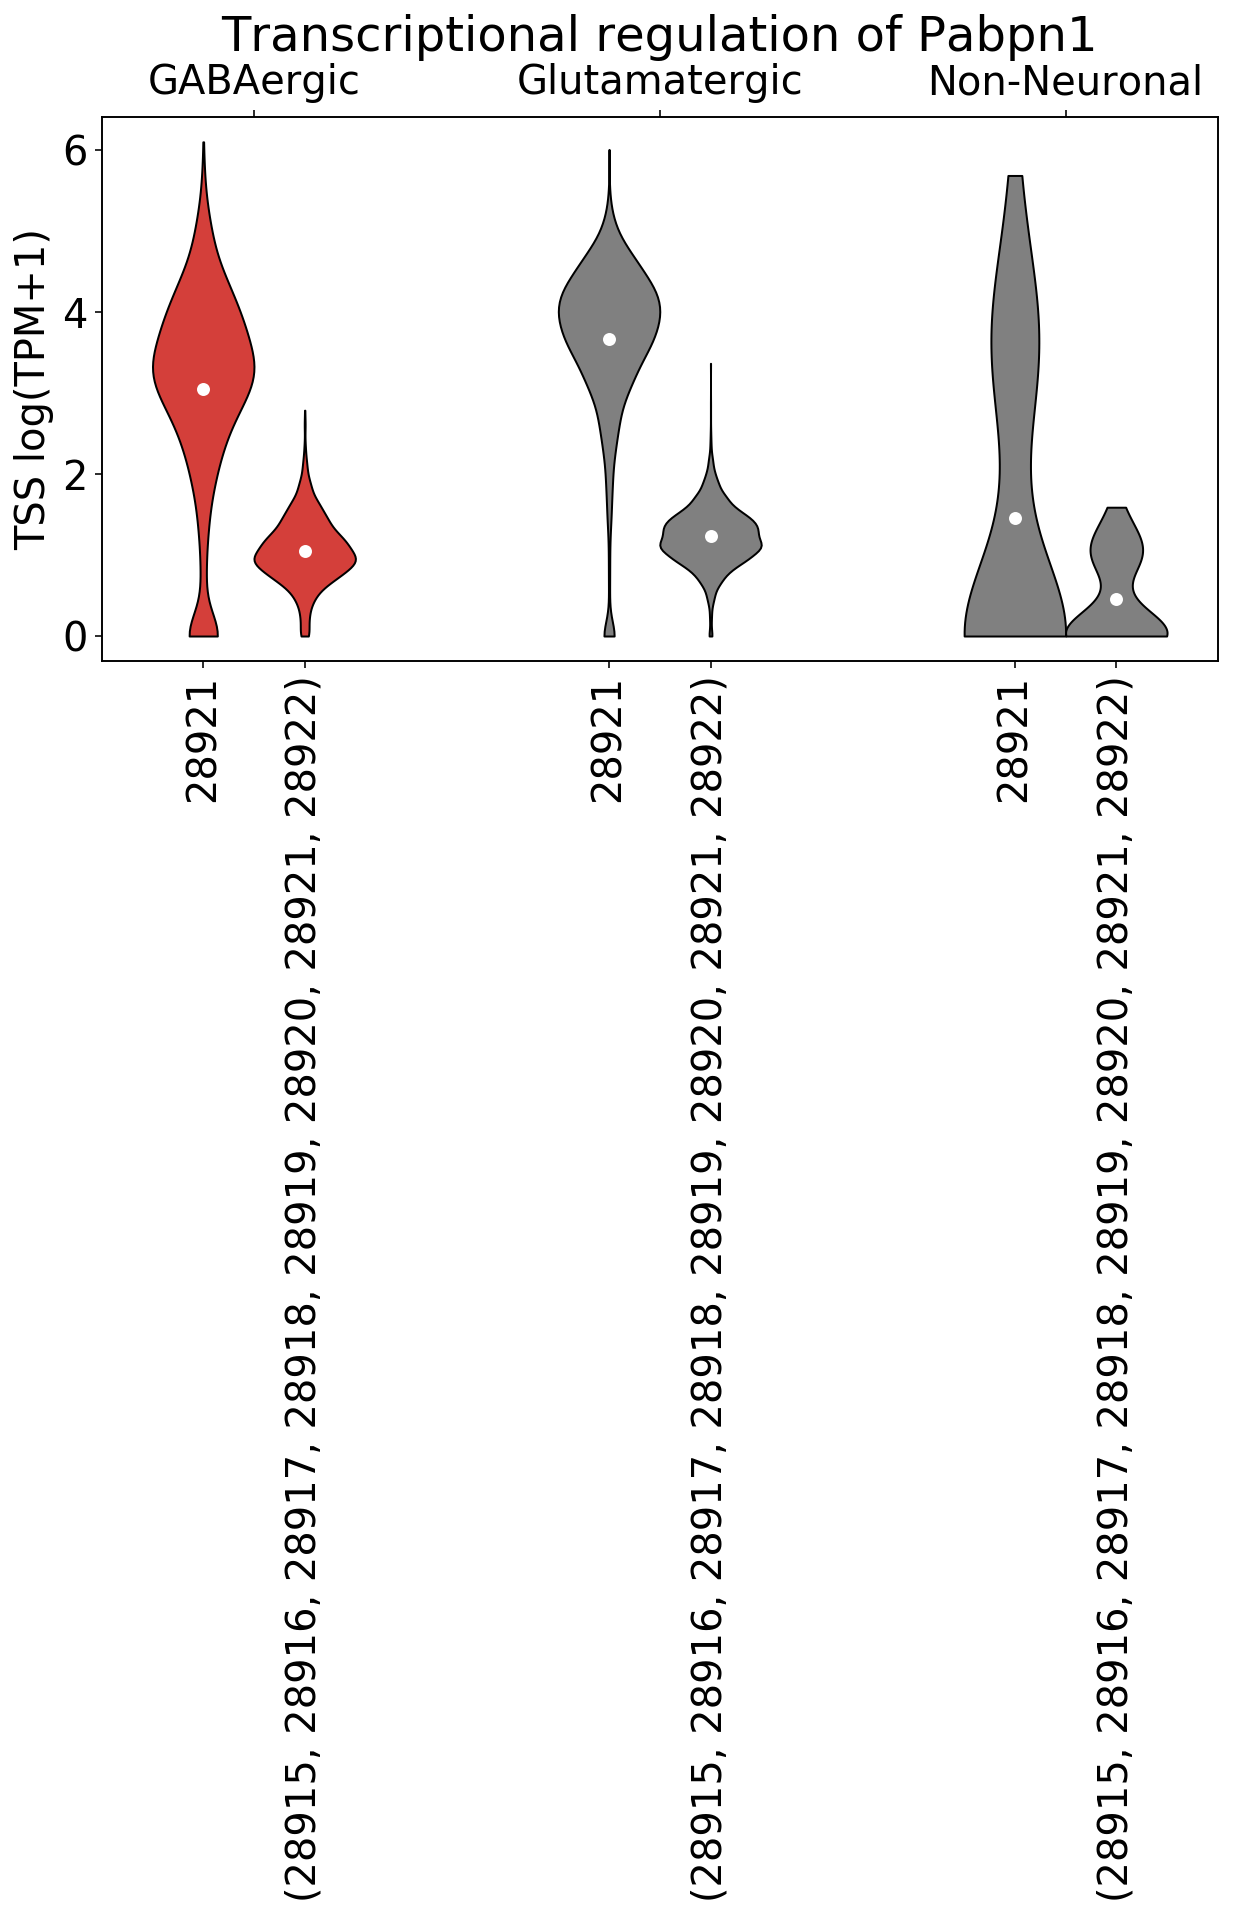

In [509]:
fig, ax = plt.subplots(figsize=(10,5))

specific_cluster = classes[idx]

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique
lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)


lridx = np.union1d(lidx, ridx)
sub_labels = [tss_0, tss_1]*len(lidx)

mat = stss.layers["log1p"]
obs = stss.obs
var = stss.var



x = []
y = []
for c in unique:
    tmp_mat = mat[obs.class_label==c,:]
    
    x.append(np.asarray(tmp_mat[:,var.tss_class==tss_0]).reshape(-1).tolist())
    tmp = []
    for t in tss_1:
        tmp.append(np.asarray(tmp_mat[:,var.tss_class==t]).reshape(-1).tolist())
    y.append(np.array(tmp).mean(axis=0))
    #y.append(np.asarray(tmp_mat[:,var.tss_class==tss_1]).reshape(-1).tolist())
    
left = ax.violinplot(x, showmedians=False, showextrema=False, positions=lidx)
right = ax.violinplot(y, showmedians=False, showextrema=False, positions=ridx)
for pcidx, pc in enumerate(left['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        
for pcidx, pc in enumerate(right['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.mean(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

medians = [np.mean(i) for i in y]
ax.scatter(ridx, medians, marker='o', color='white', s=30, zorder=3)

ax2 = ax.twiny()
ax.set_xticks(lridx)
ax.set_xticklabels(sub_labels, rotation=90, ha="center")

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(cidx)
ax2.set_xticklabels(labels, rotation=0, ha="center")

ax.set_ylabel("TSS log(TPM+1)")
ax.set_title("Transcriptional regulation of {}".format(specific_gene))

#plt.savefig("./level_3_fig/tss_violin_transcriptional_{}.png".format(specific_gene), bbox_inches='tight', dpi=300)

plt.show()

# Plot isoforms against each other

In [492]:
et2g[et2g.tss_class==tss_0]

,chromosome,gene_name,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class,filter
18158,11,Znrf3,5444847,Znrf3-201,2,2,3,2,1,18158,0
18158,11,Znrf3,5444847,Znrf3-202,2,2,3,2,1,18158,0


In [498]:
iso0, iso1 = "Znrf3-201", "Znrf3-202"

27-Feb-20 21:48:29 - update_title_pos
27-Feb-20 21:48:29 - update_title_pos
27-Feb-20 21:48:29 - update_title_pos
27-Feb-20 21:48:29 - update_title_pos
27-Feb-20 21:48:29 - update_title_pos
27-Feb-20 21:48:29 - update_title_pos
27-Feb-20 21:48:29 - update_title_pos
27-Feb-20 21:48:29 - update_title_pos


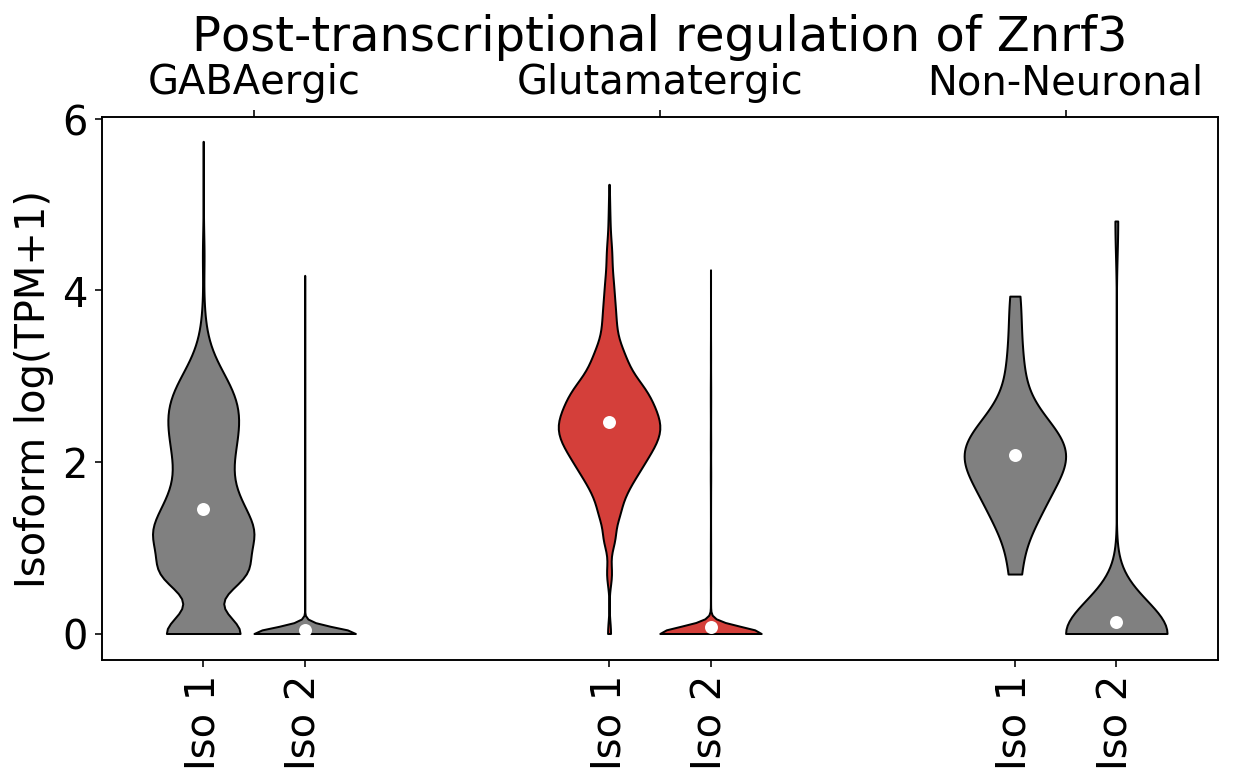

In [499]:
fig, ax = plt.subplots(figsize=(10,5))

unique = np.unique(stss.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))

midx = np.where(unique==specific_cluster)[0][0]
labels = unique


lidx = np.arange(0.25, len(labels)*2+0.25, 2)
ridx = np.arange(0.75, len(labels)*2 + 0.75, 2)
cidx = np.arange(0.50, len(labels)*2+0.5, 2)

lridx = np.union1d(lidx, ridx)
sub_labels = ["Iso 1", "Iso 2"]*len(lidx)

mat = tmp_iso.layers["log1p"].todense()
obs = tmp_iso.obs
var = tmp_iso.var



x = []
y = []
for c in unique:
    tmp_mat = mat[obs.class_label==c,:]
    
    x.append(np.asarray(tmp_mat[:,var.transcript_name==iso0]).reshape(-1).tolist())
    y.append(np.asarray(tmp_mat[:,var.transcript_name==iso1]).reshape(-1).tolist())
    
left = ax.violinplot(x, showmedians=False, showextrema=False, positions=lidx)
right = ax.violinplot(y, showmedians=False, showextrema=False, positions=ridx)
for pcidx, pc in enumerate(left['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')
        
for pcidx, pc in enumerate(right['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.mean(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

medians = [np.mean(i) for i in y]
ax.scatter(ridx, medians, marker='o', color='white', s=30, zorder=3)

ax2 = ax.twiny()
ax.set_xticks(lridx)
ax.set_xticklabels(sub_labels, rotation=90, ha="center")

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(cidx)
ax2.set_xticklabels(labels, rotation=0, ha="center")

ax.set_ylabel("Isoform log(TPM+1)")
ax.set_title("Post-transcriptional regulation of {}".format(specific_gene))
#plt.savefig("./level_3_fig/tss_violin_post-transcriptional_{}.png".format(specific_gene), bbox_inches='tight', dpi=300)

plt.show()